<a href="https://colab.research.google.com/github/leonardoLavagna/PyTorch-Notebooks/blob/main/Notebook_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Notebook 4
In this notebook, we're going to work through a couple of different classification problems with PyTorch, that is taking a set of inputs and predicting what class those set of inputs belong to. We're going to reiterate over the PyTorch workflow we coverd in Notebook 3, except instead of trying to predict a straight line, we'll be working on a classification problem.




## Get the data
We'll use the `make_circles()` method from `Scikit-Learn` (see https://scikit-learn.org/stable) to generate two circles with different coloured dots, red or blue, then we will  build a PyTorch neural network to classify dots into red or blue.

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,noise=0.03,random_state=1234)

**Remark .** The parameter `random_state=1234` is used for reproducibility purposes. Keep the same value for this parameter throughout this Notebook.

In [2]:
import pandas as pd

# Make DataFrame of circle data
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head()

,X1,X2,label
0,-0.527766,0.612121,1
1,0.753251,-0.105005,1
2,-0.345128,0.957593,0
3,-0.755676,-0.142257,1
4,0.717383,-0.693979,0


In [3]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

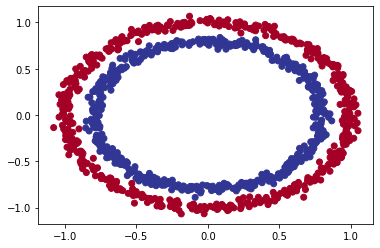

In [4]:
# Visualization
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],y=X[:, 1],c=y,cmap=plt.cm.RdYlBu);

### Tensorization

Now that we've gathered the data, we will transform them into tensors. Mind the dimension and shape og the inputs and outputs (we have 2 inputs for each output).

In [5]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

## Build or pick a model
Now our data is in tensor form, let's split it into training and test sets. To do so, let's use the function `train_test_split()` from `Scikit-Learn`.

In [6]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

It's time to build a model, by:

*   Setting up device agnostic code (so our model can run on CPU or GPU if it's available);
*   Constructing a model by subclassing nn.Module;
*   Defining a loss function and optimizer (next section);
*   Creating training and testing loops (next section). 

Adjusting the workflow to mathc a classification problem.

In [7]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
# Construct a model class that subclasses nn.Module
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 nn.Linear layers capable of handling X and y input and output shapes
        # Layer 1 takes in 2 features (X), produces 5 features
        # i.e. 5 hidden units known as neurons.
        self.layer_1 = nn.Linear(in_features=2, out_features=5) 
        # Layer 2 takes in 5 features, produces 1 feature (y)
        self.layer_2 = nn.Linear(in_features=5, out_features=1) 
    
    # Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer 2
        # Computation goes through layer 1 first then the output of layer 1 goes through layer 2
        return self.layer_2(self.layer_1(x)) 

# Create an instance of the model and send it to target device
model = CircleModel().to(device)

**Remark .** See the following equivalent model in TensorFlow to have a beeter idea of what we are doing... https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.19809&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false 

**Remark .** It is possible to generate the same model using `nn.Sequential`, but even if it is straight-forward, however, it always runs in sequential order. If you'd something else to happen you'll want to define your own custom `nn.Module` subclass.

In [9]:
# Replicate CircleModel with nn.Sequential
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

## Fit the model to the data and make inference
Now we've got a model, let's see what happens when we pass some data through it.

In [10]:
# Make predictions with the model
untrained_preds = model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst couple of predictions:\n{untrained_preds[:4]}")
print(f"\nFirst couple of test labels:\n{y_test[:4]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First couple of predictions:
tensor([[0.8769],
        [0.4974],
        [0.8622],
        [0.3560]], grad_fn=<SliceBackward0>)

First couple of test labels:
tensor([0., 0., 0., 0.])


### Loss function and optimizer
Different problem types require different loss functions and optimizers. For example, for a regression problem we used in Notebook 3 the mean absolute error (MAE) loss. For a binary classification problem (like ours), you'll often use binary cross entropy (BCE) as the loss function, see: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a. As optimizer we will keep the Stochastic Gradient Descent SGD.

In [11]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

**Remark .** In PyTorch there are two different implementations of the BCE loss, see https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586.


Now let's also create an **evaluation metric**. If a loss function measures how wrong your model is, we can think of an evaluation metrics as measure about how right the model is is. Both of these are doing the same thing, but evaluation metrics offer a different perspective. There are several evaluation metrics that can be used for classification problems but let's start out with **accuracy**. Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

In [12]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

### Training loop and Testing loop
Before starting the training and testing loops we need to adapt the raw outputs of our model (often called **logits**, see https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean/31045#31045) to a classification problem, namely we need to transform them into **prediction probabilities**. To get our model's raw outputs (logits) into such a form, we can use the **sigmoid activation function**, see https://en.wikipedia.org/wiki/Sigmoid_function. Then we can turn our prediction probabilities in **prediction labels** by rounding the outputs of the sigmoid activation function.

In [13]:
torch.manual_seed(1234)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### TRAINING
    model.train()

    # Forward pass
    # Squeeze to remove extra `1`  dimensions
    # This won't work unless model and data are on same device 
    y_logits = model(X_train).squeeze() 
    # logits -> pred probs -> pred labls
    y_pred = torch.round(torch.sigmoid(y_logits)) 
  
    # Calculate loss/accuracy
    loss = loss_fn(y_logits,y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred) 

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backwards pass
    loss.backward()

    # Optimizer step
    optimizer.step()

    ### TESTING
    model.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Caculate loss/accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    # Print out what's happening every 20 epochs
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:}, Accuracy: {acc:}% | Test loss: {test_loss:}, Test acc: {test_acc:}%")


Epoch: 0 | Loss: 0.7412845492362976, Accuracy: 50.24999999999999% | Test loss: 0.7402693033218384, Test acc: 49.0%
Epoch: 20 | Loss: 0.6993120312690735, Accuracy: 50.24999999999999% | Test loss: 0.6995742917060852, Test acc: 49.0%
Epoch: 40 | Loss: 0.6941745281219482, Accuracy: 59.5% | Test loss: 0.694145679473877, Test acc: 53.5%
Epoch: 60 | Loss: 0.6934324502944946, Accuracy: 52.25% | Test loss: 0.6933481097221375, Test acc: 54.0%
Epoch: 80 | Loss: 0.6932517290115356, Accuracy: 50.875% | Test loss: 0.6932584643363953, Test acc: 52.0%


## Evaluate the model

It looks like it went through the training and testing steps fine but the results don't seem to have moved too much. The accuracy barely moves above 50% on each data split. And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

Let's make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1. To do so, we'll write some code to download and import the `helper_functions.py` script (see: https://github.com/leonardoLavagna/PyTorch-Notebooks/blob/main/helper_functions.py)

In [14]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/leonardoLavagna/PyTorch-Notebooks/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


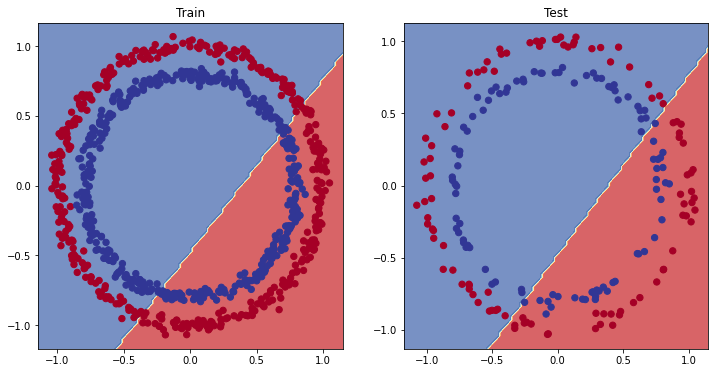

In [15]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

it seems like we've found the cause of model's performance issue. It's currently trying to split the red and blue dots using a straight line... In machine learning terms, our model is **underfitting**, meaning it's not learning predictive patterns from the data.

## Improve by experimentation

Focusing specifically on the model (not the data), there are a few ways we could do this:


*   Add more layers
*   Add more hidden units
*   Fitting for longer (more epochs)
*   Changing the activation functions
*   Change the learning rate
*   Change the loss function
*   and more...

Let's see what happens if we add an extra layer to our model, fit for longer (epochs=1000 instead of epochs=100) and increase the number of hidden units from 5 to 10. We'll follow the same steps we did above but with a few changed hyperparameters.



In [16]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): 
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [18]:
torch.manual_seed(42)

epochs = 1000 

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69381, Accuracy: 48.88% | Test loss: 0.69381, Test acc: 47.00%
Epoch: 200 | Loss: 0.69307, Accuracy: 51.12% | Test loss: 0.69422, Test acc: 48.50%
Epoch: 400 | Loss: 0.69305, Accuracy: 50.62% | Test loss: 0.69408, Test acc: 49.50%
Epoch: 600 | Loss: 0.69305, Accuracy: 51.12% | Test loss: 0.69401, Test acc: 50.00%
Epoch: 800 | Loss: 0.69305, Accuracy: 51.38% | Test loss: 0.69398, Test acc: 50.00%



What? Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing. Let's visualize.

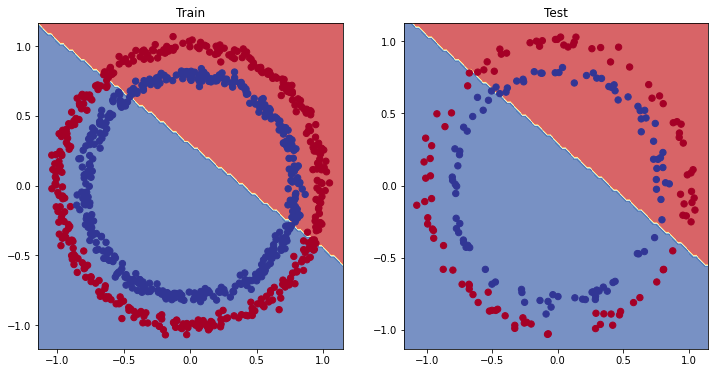

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Our model is still drawing a straight line between the red and blue dots. wW introduce the capability for our model to use **non-linear actviation functions**.



In [20]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        # add in ReLU activation function
        self.relu = nn.ReLU() 
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)

In [21]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [22]:
# FIT THE MODEL
torch.manual_seed(1234)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # TRAINING

    # Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    
    # Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
    
    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    ### TESTING
    model_3.eval()
    with torch.inference_mode():
      # Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      # Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:}, Accuracy: {acc:}% | Test Loss: {test_loss:}, Test Accuracy: {test_acc:}%")

Epoch: 0 | Loss: 0.6930180191993713, Accuracy: 50.24999999999999% | Test Loss: 0.6928169131278992, Test Accuracy: 49.0%
Epoch: 200 | Loss: 0.6890699863433838, Accuracy: 56.00000000000001% | Test Loss: 0.6896149516105652, Test Accuracy: 52.5%
Epoch: 400 | Loss: 0.6818337440490723, Accuracy: 55.375% | Test Loss: 0.6849011778831482, Test Accuracy: 52.5%
Epoch: 600 | Loss: 0.6648517847061157, Accuracy: 55.625% | Test Loss: 0.6733404397964478, Test Accuracy: 57.49999999999999%
Epoch: 800 | Loss: 0.625072181224823, Accuracy: 70.625% | Test Loss: 0.641777753829956, Test Accuracy: 68.5%


That's looking far better!

In [23]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()


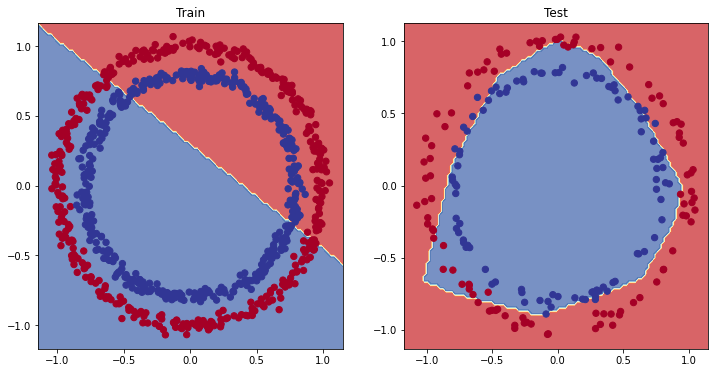

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
# model_1 = no non-linearity
plot_decision_boundary(model_1, X_train, y_train) 
plt.subplot(1, 2, 2)
plt.title("Test")
# model_3 = has non-linearity
plot_decision_boundary(model_3, X_test, y_test) 